In [4]:
import matplotlib.pyplot as plt

from knetworks import knetworks, Network
import numpy as np
from testdata.generator import generateFromGenFile
import torch
import os
%matplotlib inline

%config InlineBackend.figure_format='retina'
if torch.cuda.is_available():
	train_on = "cuda"
else:
	train_on = "cpu"
device = torch.device(train_on)

In [5]:
filename = os.getcwd() + "/../" + "allproducts.txt" #may not work for windows
with open(filename, "r") as file:
    f = file.read()
    products = f.split("\n")

products = [p.upper() for p in products]

features = []
vectors = []
data = [[] for i in range(19)] # warning #cleancode
for f in range(1, 20):
    file = open("testdata/gu_" + str(f) + ".txt", "r") 
    lines = file.readlines()
    features = sorted(str(lines[0]).replace(" ", "").upper().strip().split(","))
    vect = []
    for l in range(len(lines)-1):
        data[f-1].append([])
        vec = lines[l+1].upper().split(",")
        for i in range(len(vec)):
            if int(float(vec[i])) == 1:
                data[f-1][l].append(features[i])
    vectors.append(np.array(vect))

In [6]:
vectors = [np.array([np.zeros(len(products), dtype=np.int) for gr_list in range(len(data[user]))]) for user in range(len(data))]
for i,x in enumerate(data):
    for j,y in enumerate(x):
        for k,f in enumerate(products):
            if f in y:
                vectors[i][j][k] = 1

In [7]:
knet = knetworks(6, vectors[:-4], len(products), device) # create a knetworks object

In [8]:
#knet.load("saves") # loading a savestate

In [9]:
#knet.fit() # fit the centroids to the data (using 7 datapoints for the mean <-- not true anymore, right?)

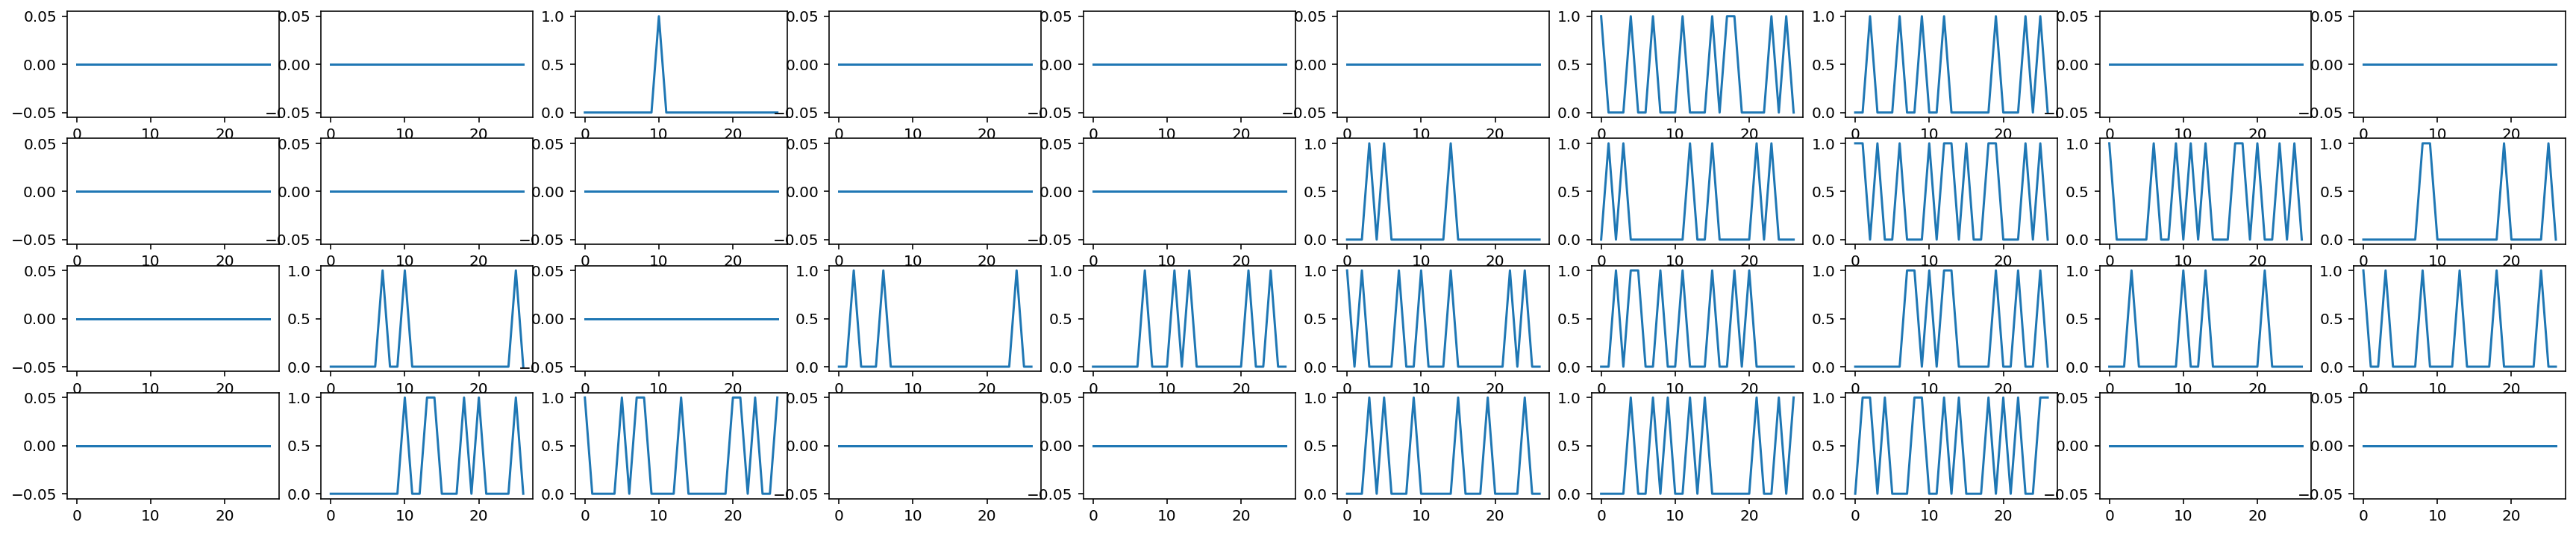

In [10]:
# Plotting the first 10 product from every user
# orange: training-set
# blue: the ground truth to be predicted by the model
f, axes = plt.subplots(4, 10, figsize=(30, 6))
count = 0
for i in range(4):
    for j in range(10):
        if count < len(products):
            axes[i][j].plot(np.array(vectors)[i][:,j])
            count += 1

In [13]:
#knet.train(350,1) # weighted training on the CN's
knet.load(os.getcwd() + "/saves")

In [14]:
#knet.save("saves") # saving a savestate

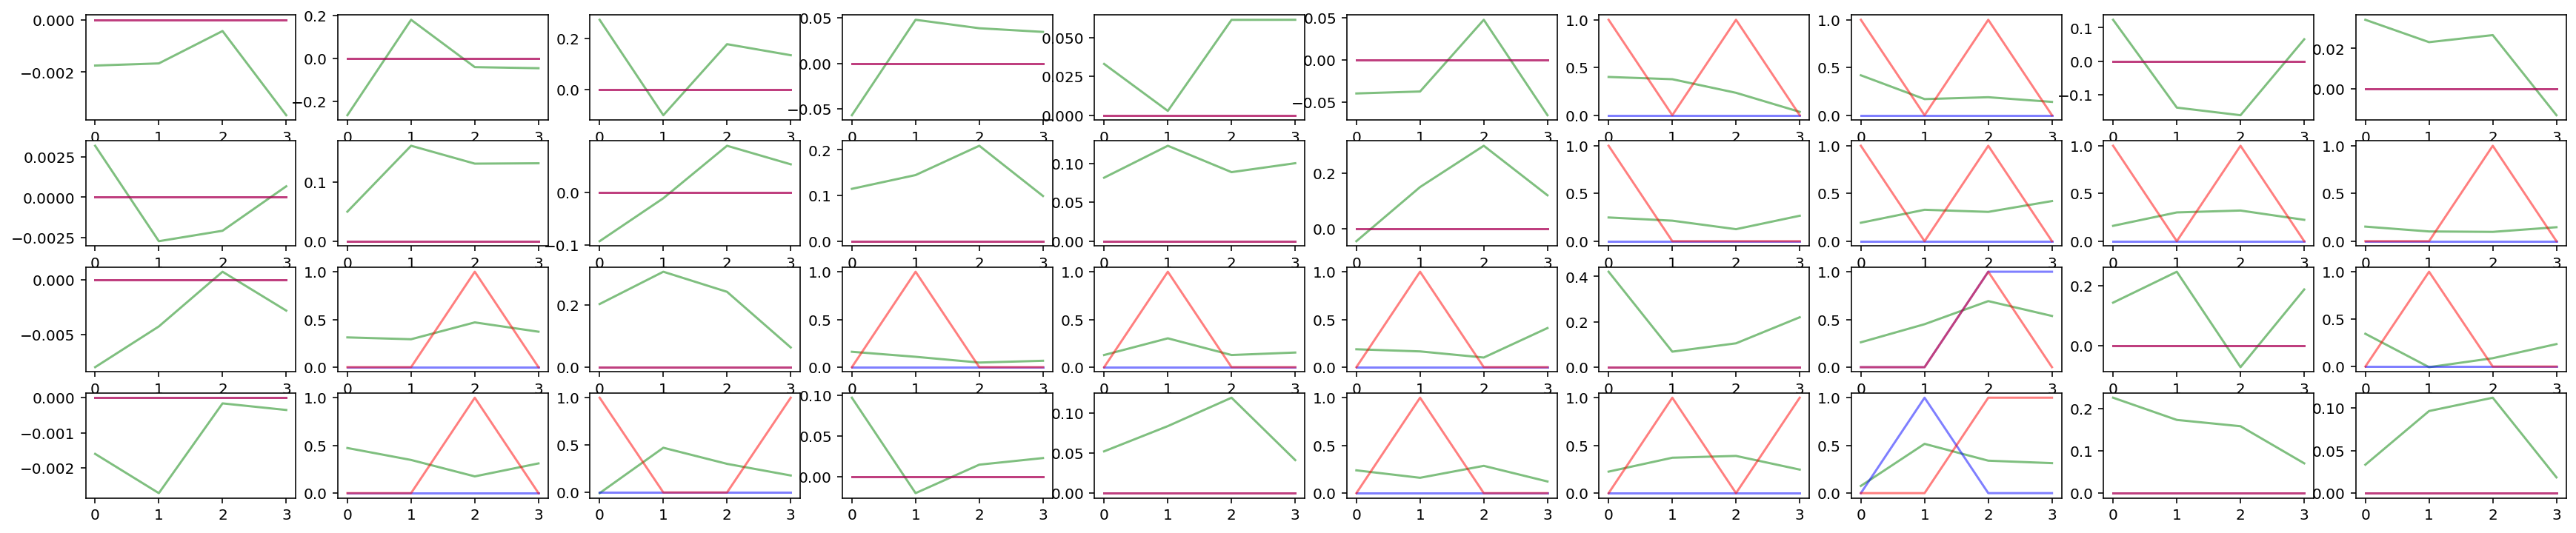

In [15]:
# red: ground truth
# green: prediction
# blue: rounded prediction

f, axes = plt.subplots(4, 10, figsize=(30, 6))
for i in range(4):
    prediction = np.array(np.squeeze(knet.predict(vectors[i], future=4)))
    for j in range(10):
        axes[i][j].plot(prediction[:,j], c='g', alpha=0.5)
        axes[i][j].plot(np.round(prediction[:,j]), alpha=0.5 , c='b')
        axes[i][j].plot(vectors[i][-4:,j], c='r', alpha=0.5)


In [37]:
def eval(knet):
    r_gs = []
    f_ps = []
    f_ns = []
    t_ps = []
    n = len(products)
    for user in range(19):
        prediction = np.array(np.squeeze(knet.predict(vectors[user], future=1))) # the prediction for user
        wrong_guesses = np.sum(np.absolute((np.absolute(np.round(prediction)) - vectors[user][-4,:]))) # the right guessed features for one receipt into the future
        false_postives = np.sum(np.maximum((np.absolute(np.round(prediction)) - vectors[user][-4,:]), 0))
        false_negatives = np.sum(np.maximum((vectors[user][-4,:] - np.absolute(np.round(prediction))), 0))
        true_positives = np.sum((np.round(prediction) + vectors[user][-4,:])//2)
        right_guesses = n - wrong_guesses
        true_negatives = right_guesses - true_positives
        r_gs.append(right_guesses)
        f_ps.append(false_postives)
        f_ns.append(false_negatives)
        t_ps.append(true_positives)
        #print(false_postives, false_negatives)
        #print("["+ str(user) + "] Accuracy: " + str(len(products)-int(wrong_guesses)) + "/" + str(len(products)) + " (" + str((len(products)-int(wrong_guesses))/len(products)) + ")")
    m_r_gs = np.mean(r_gs)
    m_f_ps = np.mean(f_ps)
    m_f_ns = np.mean(f_ns)
    m_t_ps = np.mean(t_ps)
    print("TP,FP,FN: ", m_t_ps, m_f_ps, m_f_ns)
    print("Accuracy: ", m_r_gs / n)
    print("True positive rate (recall) (correctly predicted of all YES values): ", m_t_ps / (m_t_ps + m_f_ns))
    print("Precision (correctly predicted of all YES predicted): ", m_t_ps / (m_t_ps + m_f_ps))

In [17]:
#filepath = "saves"
#for i, net in enumerate(knet.networks):
#    torch.save(net.model.state_dict(), filepath + "/models/CN_" + str(i) + ".pth")
        
# save the centroids array
#np.savetxt(filepath + '/centroids.csv', knet.centroids, delimiter=',')
# save the distances array
#np.savetxt(filepath + '/distances.csv', knet.D, delimiter=',')
# save the weights array
#np.savetxt(filepath + '/weights.csv', knet.W, delimiter=',')

In [ ]:
#make metric true positives / (true positives + false negatives) and TP/(TP+FP) ??

In [18]:
#create one network for all users to compare the results
knet2 = knetworks(1, vectors[:-4], len(products), device) # create a knetworks object

In [19]:
knet2.fit()

In [20]:
knet2.train(350,1)

We are going to train 1 networks for 1 epochs with 350 samples each.


In [38]:
eval(knet)

TP,FP,FN:  3.210526315789474 3.789473684210526 9.894736842105264
Accuracy:  0.9559993230665087
True positive rate (recall) (correctly predicted of all YES values):  0.24497991967871485
Precision (correctly predicted of all YES predicted):  0.4586466165413534


In [39]:
eval(knet2)

TP,FP,FN:  4.052631578947368 6.473684210526316 8.68421052631579
Accuracy:  0.9512607886275174
True positive rate (recall) (correctly predicted of all YES values):  0.3181818181818182
Precision (correctly predicted of all YES predicted):  0.38499999999999995
